# Non-Unitary Operators for the Non-Hermitian Skin Effect

Paper to be replicated: https://arxiv.org/pdf/2311.10143

Addition Resources Consulted:
- https://link.aps.org/pdf/10.1103/PRXQuantum.2.010342
- https://medium.com/mdr-inc/time-evolution-operators-be2968493b86 (note there are some notable errors)
- 

In [1]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp, Statevector, Operator
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler
# from qiskit.primitives import Sampler
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from qiskit.transpiler import CouplingMap
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.circuit.library import UnitaryGate
from qiskit.quantum_info import Statevector

# from tqdm.notebook import tqdm

from numpy import sin, cos
import numpy as np
from scipy.linalg import expm, sqrtm

from scipy.optimize import differential_evolution, dual_annealing, minimize

from itertools import product

import random

import json

import csv





In [2]:
# service = QiskitRuntimeService()
BACKEND = AerSimulator()
pass_manager = generate_preset_pass_manager(backend=BACKEND, optimization_level=0)
estimator = Estimator(mode=BACKEND)
sampler = Sampler(mode=BACKEND)

## I. Hatano-Nelson Model

Note $\hat{X}^+ = \frac{\hat{X} + i \hat{Y}}{2}$ and $\hat{X}^- = \frac{\hat{X} - i \hat{Y}}{2}$

In [3]:
X_gate = np.array([[0, 1], 
                   [1, 0]])

Y_gate = np.array([[0, -1j],
                   [1j, 0]])

I_gate = np.array([[1, 0], 
                   [0, 1]])

X_plus = 0.5 * (X_gate + 1j * Y_gate)
X_minus = 0.5 * (X_gate - 1j * Y_gate)

In [4]:
# Helper function, generates U_j_nonH
def get_U_j_nonH(J, gamma, index, N, timestep):
    product_1 = np.kron(X_plus, X_minus)
    product_2 = np.kron(X_minus, X_plus)
    exponent = 1j * timestep * ( (J - gamma) * product_1 + (J + gamma) * product_2)
    
    if index == 0:
        U_j_nonH = np.kron(np.eye(2 ** (N-2)), expm(exponent))
    if index == N - 2:
        U_j_nonH = np.kron(expm(exponent), np.eye(2 ** (N-2)))
    else: 
        U_j_nonH = np.kron(np.kron(np.eye(2 ** (N - 2 - index)), expm(exponent)), np.eye(2 ** (index)))
    return U_j_nonH
    


# Helper function, generates R_HN
def get_R_HN(J, gamma, N, timestep):
    res_even = np.eye(2 ** N)
    res_odd = np.eye(2 ** N)
    for i in range(N - 1):
        if i % 2 == 0:
            res_even = np.matmul(res_even, get_U_j_nonH(J, gamma, i, N, timestep))
        else:
            res_odd = np.matmul(res_odd, get_U_j_nonH(J, gamma, i, N, timestep))
    return np.matmul(res_even, res_odd)

# Generates U_HN 
def get_U_HN(J, gamma, N, timestep):
    R_HN = get_R_HN(J, gamma, N, timestep)

    A, sig, Bh = np.linalg.svd(R_HN)
    eigval, _ = np.linalg.eig(np.matmul(R_HN.conj().T, R_HN))
    u_square_inverse = max(eigval)
    u_square = 1/u_square_inverse 
    C = np.matmul(np.matmul(A, sqrtm(np.eye(2 ** N) - u_square * np.diag(np.square(sig)))), Bh)

    u_R_HN = np.sqrt(u_square) * R_HN
    W = np.concatenate((np.concatenate((u_R_HN, C), axis=0), np.concatenate((np.eye(2 ** N), np.eye(2 ** N)), axis=0)), axis=1)
    U_HN, _ = np.linalg.qr(W)
    return U_HN

In [5]:
def projection(N):
    projector = np.array([[1.0, 0.0], [0.0, 0.0]])
    
    return np.kron(projector, np.eye(2 ** (N-1)))

projection(3)

array([[1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0.]])

In [6]:
total_time = 1.8
nb_timesteps = 10
timestep_duration = total_time/nb_timesteps

# Mathematical implementation of Hamiltonian
Note: Qiskit was not used

(6, 10)


Text(0.5, 0, 'T')

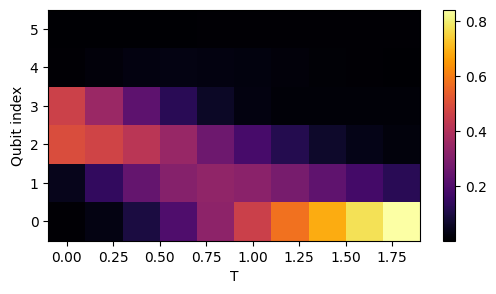

In [7]:
# For gamma = 0.5 case 
# (Full matrices and state vector based, no qiskit)
N = 6
nb_timesteps = 10
timestep_duration = 0.2
gamma = 0.5
J = 1

# Generate the unitary
matrix = get_U_HN(J, gamma , N, timestep_duration)
projection_matrix = projection(N+1)

# create the initial state vector (|↓↓↑↓↓↓⟩+|↓↓↓↑↓↓⟩)/ 2
initial_vector = np.zeros((2**(N+1), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)

magnetization=[]
for n_steps in range(1, nb_timesteps + 1):

    # for each time step, apply the matrix n_steps times onto the initial vector
    state_vector = np.matmul(np.linalg.matrix_power(matrix @ projection_matrix, n_steps), initial_vector).T[0]
    state_dict = {}
    for i in range(2 ** (N+1)):

        # allocate the relevant probabilities to each state
        state_dict[bin(i)[2:].zfill(N+1)] = np.abs(state_vector[i]) ** 2

   
    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in state_dict.items():

        # key[0] is the ancillary qubit
        if key[0] == '0':
            prob += value
            for i in range(1, N + 1):

                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i] += value

    magnetization += [[x/prob for x in row]]

magnetization = np.array(magnetization)
print(magnetization.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), magnetization.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

# Adapting to Quantum Circuit Ansatz

### Mathematical Target Unitary/Hamiltonian (same as above but considering Qiskit's little endian)

(6, 10)


Text(0.5, 0, 'T')

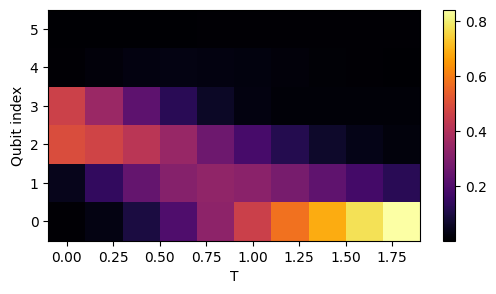

In [8]:
# For gamma = 0.5 case 
# (Full matrices and state vector based, no qiskit)
N = 6
nb_timesteps = 10
timestep_duration = 0.2
gamma = 0.5
J = 1

# Generate the unitary
matrix = get_U_HN(J, gamma , N, timestep_duration)
projection_matrix = projection(N+1)

# create the initial state vector (|↓↓↑↓↓↓⟩+|↓↓↓↑↓↓⟩)/ 2
initial_vector = np.zeros((2**(N+1), 1), dtype=complex)
initial_vector[ (2**N - 1) - 2**(N//2)] = 1/np.sqrt(2)
initial_vector[ (2**N - 1) - 2**(N//2 -1)] = 1/np.sqrt(2)

probabilities=[]
target_states = {}
for n_steps in range(0, nb_timesteps + 1):

    # for each time step, apply the matrix n_steps times onto the initial vector
    # state_vector = np.matmul(np.linalg.matrix_power(matrix @ projection_matrix , n_steps), initial_vector).T[0]
    state_vector = np.matmul(np.linalg.matrix_power(projection_matrix @ matrix, n_steps), initial_vector).T[0]
    states = np.array([0j for i in range(2 ** (N+1))])
    probs_dict = {}

    for i in range(2 ** (N+1)):

        # allocate the relevant probabilities to each state
        # to consider little endian of qiskit:
        string = bin(i)[2:].zfill(N+1)
        string = string[1:] + string[0]
        probs_dict[string] = np.abs(state_vector[i]) ** 2
        states[int(string, 2)] = state_vector[i]
    target_states[n_steps] = states
   
    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in probs_dict.items():

        # key[0] is the ancillary qubit
        if key[-1] == '0':
            prob += value
            for i in range(0, N):

                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i - 1] += value
        #else:
        #    print(value)
    if n_steps > 0:
        probabilities += [[x/prob for x in row]]

probabilities = np.array(probabilities)
print(probabilities.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), probabilities.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

### Mathematical model of Quantum Circuit Ansatz
Starting state is an equal superposition of all states (H gate on all qubits)

In [9]:
def unitary_gate_matrix(theta, phi, lam):
    return np.array([[np.cos(theta/2), -np.exp(lam * 1j) * np.sin(theta/2)],
                    [np.exp(phi * 1j) * np.sin(theta/2), np.exp(1j * (phi + lam)) * np.cos(theta/2)]])

cx_matrix = np.array([[1, 0, 0, 0], 
                     [0, 0, 0, 1], 
                     [0, 0, 1, 0],
                     [0, 1, 0, 0]])

cx_matrices = np.kron(np.kron(cx_matrix, cx_matrix), cx_matrix)

cx_matrix_v1 = np.kron(np.eye(2), cx_matrices)
cx_matrix_v2 = np.kron(cx_matrices, np.eye(2))

In [10]:
def variational_circuit_mathematical(params, layers):
    stepper = 0

    #state = np.zeros((2**(N+1), 1), dtype=complex) #initial_vector.copy()
    state = np.full((2**(N+1), 1), np.sqrt(1.0/2**(N+1)))
    #state = np.zeros((2**(N+1), 1), dtype=complex)
    #state[0] = 1
    #state = initial_vector.copy()

    
    matrix = unitary_gate_matrix(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2])
    stepper += 1
    for _ in range(N):
        matrix = np.kron(unitary_gate_matrix(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2]), matrix)
        stepper += 1
    state = np.matmul(matrix, state)


    for _ in range(layers):
        state = np.matmul(cx_matrix_v1, state)
        matrix = unitary_gate_matrix(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2])
        stepper += 1
        for _ in range(N - 1):
            matrix = np.kron(unitary_gate_matrix(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2]), matrix)
            stepper += 1
        matrix = np.kron(np.eye(2), matrix)
        state = np.matmul(matrix, state)
        state = np.matmul(cx_matrix_v1, state)

        state = np.matmul(cx_matrix_v2, state)
        matrix = np.eye(2)
        for _ in range(N):
            matrix = np.kron(unitary_gate_matrix(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2]), matrix)
            stepper += 1
        state = np.matmul(matrix, state)
        state = np.matmul(cx_matrix_v2, state)
    
    return state
        

### Cost Function

In [11]:
def cost_function_math(params, layers, n_steps): 
    v = variational_circuit_mathematical(params, layers)     
    t = target_states[n_steps]                               
    v = v / np.linalg.norm(v)
    t = t / np.linalg.norm(t)
    overlap = np.vdot(v, t)
    return 1.0 - (overlap.conjugate() * overlap).real       


### Quantum Circuit Ansatz

In [12]:
def variational_circuit(params, layers):
    qc = QuantumCircuit(N+1)
    stepper = 0

    qc.h(range(N+1))

    # initial
    for qubit in range(N+1):
        qc.u(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2], qubit) #N - qubit)
        stepper += 1
    
    for layer in range(layers):
        # CX gates
        qc.cx(0, 1)
        qc.cx(2, 3)
        qc.cx(4, 5)

        # first set of U3 gates
        for qubit in range(N):
            qc.u(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2], qubit) 
            stepper += 1
        
        # CX gates
        qc.cx(0, 1)
        qc.cx(2, 3)
        qc.cx(4, 5)

        # CX gates
        qc.cx(1, 2)
        qc.cx(3, 4)
        qc.cx(5, 6)

        # first set of U3 gates
        for qubit in range(N):
            qc.u(params[stepper * 3 + 0], params[stepper * 3 + 1], params[stepper * 3 + 2], qubit + 1)
            stepper += 1
        
        # CX gates
        qc.cx(1, 2)
        qc.cx(3, 4)
        qc.cx(5, 6)

    qc.measure_all()

    return qc

In [13]:
def calculate_results(params, layers):

    # initialization of the sampler
    sampler = Sampler(mode=BACKEND)
    
    # Sampler runs a job on the Bell circuit
    job = sampler.run([(variational_circuit(params, layers))])
    job_result = job.result()
    return job_result[0].data.meas.get_counts(), job_result[0].metadata['shots']

### Simple optimization for number of layers

In [14]:
def create_params(layers):
    params = np.array([np.pi/4 for i in range(((N+1) + (N * 2 * layers)) * 3)])
    return params

def create_bounds(layers): # not used
    bounds = tuple([(0.0, np.pi) if i % 3 == 0 else (0.0, 2 * np.pi) for i in range(((N+1) + (N * 2 * layers)) * 3)])
    return bounds

In [15]:
optimal_layers = [0 for _ in range(nb_timesteps)]
FIND_PARAMETERS = False

In [16]:
if FIND_PARAMETERS == True:
    n_steps = 3 # 1 to nb_timesteps (for reference: for n_steps in range(1, nb_timesteps + 1), nb_timesteps = 1)
    print("Step number: ", n_steps)
    min_cost = 1
    for layers in range(1, 8+1):
        params = create_params(layers)
        sum_of_cost = 0.0
        for _ in range(2): # using 2 iterations to find average error
            res = minimize(cost_function_math, params, args=(layers, n_steps), method='L-BFGS-B') #, options={'ftol': 1E-10, 'gtol': 1E-10, 'maxfun': 100000, 'maxiter': 100000})
            sum_of_cost += cost_function_math(res.x, layers, n_steps)
        if min_cost >= sum_of_cost/5:
            optimal_layers[n_steps - 1] = layers
else:
    optimal_layers = [8 for _ in range(nb_timesteps)]

### Optimization of Parameters and Simulation on Simulator.

In [17]:
if FIND_PARAMETERS == True:
    params_dict = {}
    for n_steps in range(1, nb_timesteps + 1):
        print("Step number: ", n_steps)
        layers = optimal_layers[n_steps - 1]
        params = create_params(layers)
        res = minimize(cost_function_math, params, args=(layers, n_steps), method='L-BFGS-B', options={'ftol': 1E-10, 'gtol': 1E-10, 'maxfun': 100000, 'maxiter': 100000})
        print(cost_function_math(res.x, layers, n_steps))

        params_dict[n_steps] = res.x

In [18]:
if FIND_PARAMETERS == True:
    data = []
    for n_steps in range(1, nb_timesteps + 1):
        data.append(params_dict[n_steps])
        
    with open('params_new.csv', 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(data)

In [20]:
data = []
with open('params.csv', 'r') as file:
    csvFile = csv.reader(file)
    for lines in csvFile:
        data.append([float(value) for value in lines])

params_dict = {}
for n_steps in range(1, nb_timesteps + 1):
    params_dict[n_steps] = data[n_steps-1]

print(params_dict)

{1: [0.48197284259362655, 0.5210706540881131, 0.6949856851046731, 0.964456081137882, 0.960717761873053, 0.9132418277950639, 0.5055655625755826, 0.8052391037022666, 1.1652618699366077, 0.6792192686593167, 0.632193994967802, 0.6444122311227946, 1.019638076340375, 0.5494710208481774, 0.3496942854528326, 0.498115855356605, 0.8162019876546134, 1.1013588327237418, 0.23800242180371908, 0.6492684880956441, 0.8993556162724939, 0.693222723587938, 0.5809218824386345, 0.5210899266646041, 0.4662643078503294, 0.8687803534189787, 0.916519314205635, 0.9269418577449579, 0.16090059115335228, 0.8052628296819212, 0.4722973136070836, 0.37433289934537317, 0.3963794868731627, 0.7219527531375296, 0.997960316569317, 0.5494393384224214, 1.0498276959055828, 0.6923856695743745, 1.2267897588159047, 1.269900192721339, 0.4457802339896481, 1.0026755474373976, 1.3059889779507619, 1.567166683580652, 1.5776739477689674, 0.688686800625838, 0.9564260048823423, 0.7914003238341841, 0.3419005944460543, 0.4216682671014944, 0.

{'1110110': 507, '1101110': 464, '1111010': 44, '1011110': 4, '1111100': 5}
{'1110110': 504, '1101110': 337, '1111010': 141, '1111100': 31, '1011110': 11}
{'1111100': 105, '1111010': 241, '1110110': 418, '1101110': 238, '1011110': 21, '0111110': 1}
{'1110110': 351, '1111100': 203, '1111010': 329, '1101110': 115, '1011110': 23, '0111110': 3}
{'1111010': 335, '1111100': 321, '1110110': 286, '1101110': 59, '0111110': 4, '1011110': 19}
{'1111100': 448, '1111010': 349, '1110110': 186, '1011110': 23, '0111110': 2, '1101110': 16}
{'1111100': 608, '1110110': 100, '1111010': 284, '1011110': 12, '1101110': 17, '0111110': 3}
{'1111100': 668, '1111010': 256, '1110110': 74, '1011110': 6, '1101110': 13, '0111110': 7}
{'1111100': 787, '1111010': 175, '1101110': 11, '1110110': 42, '1011110': 4, '0111110': 5}
{'1111100': 882, '1111010': 110, '1101110': 10, '1011110': 1, '1110110': 16, '0111110': 5}
(6, 10)


Text(0.5, 0, 'T')

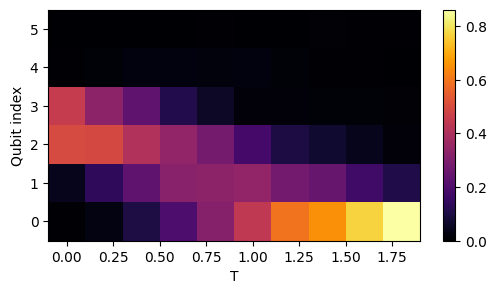

In [21]:
res_all_circuits = []
for n_steps in range(1, nb_timesteps + 1):
    res, counts = calculate_results(params_dict[n_steps], optimal_layers[n_steps-1])
    print(res)

    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in res.items():

        
        if key[-1] == "0":
            prob += value
            #for i in range(0, N):
            for i in range(0, N):
                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i - 1] += value

    res_all_circuits += [[x/prob for x in row]]

res_all_circuits = np.array(res_all_circuits)

print(res_all_circuits.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), res_all_circuits.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')

In [ ]:
# service = QiskitRuntimeService()
BACKEND = AerSimulator()
pass_manager = generate_preset_pass_manager(backend=BACKEND, optimization_level=0)
estimator = Estimator(mode=BACKEND)
sampler = Sampler(mode=BACKEND)

In [ ]:
# Save your API key to track your progress and have access to the quantum computers

your_api_key = "" # Redacted
your_crn = "" # Redacted

from qiskit_ibm_runtime import QiskitRuntimeService

QiskitRuntimeService.save_account(
    channel="ibm_quantum_platform",
    token=your_api_key,
    instance=your_crn,
    overwrite=True
)

In [38]:
service = QiskitRuntimeService()
backend = service.least_busy(operational=True, simulator=False)
print(f"We are using the {backend.name} quantum computer")


We are using the ibm_fez quantum computer


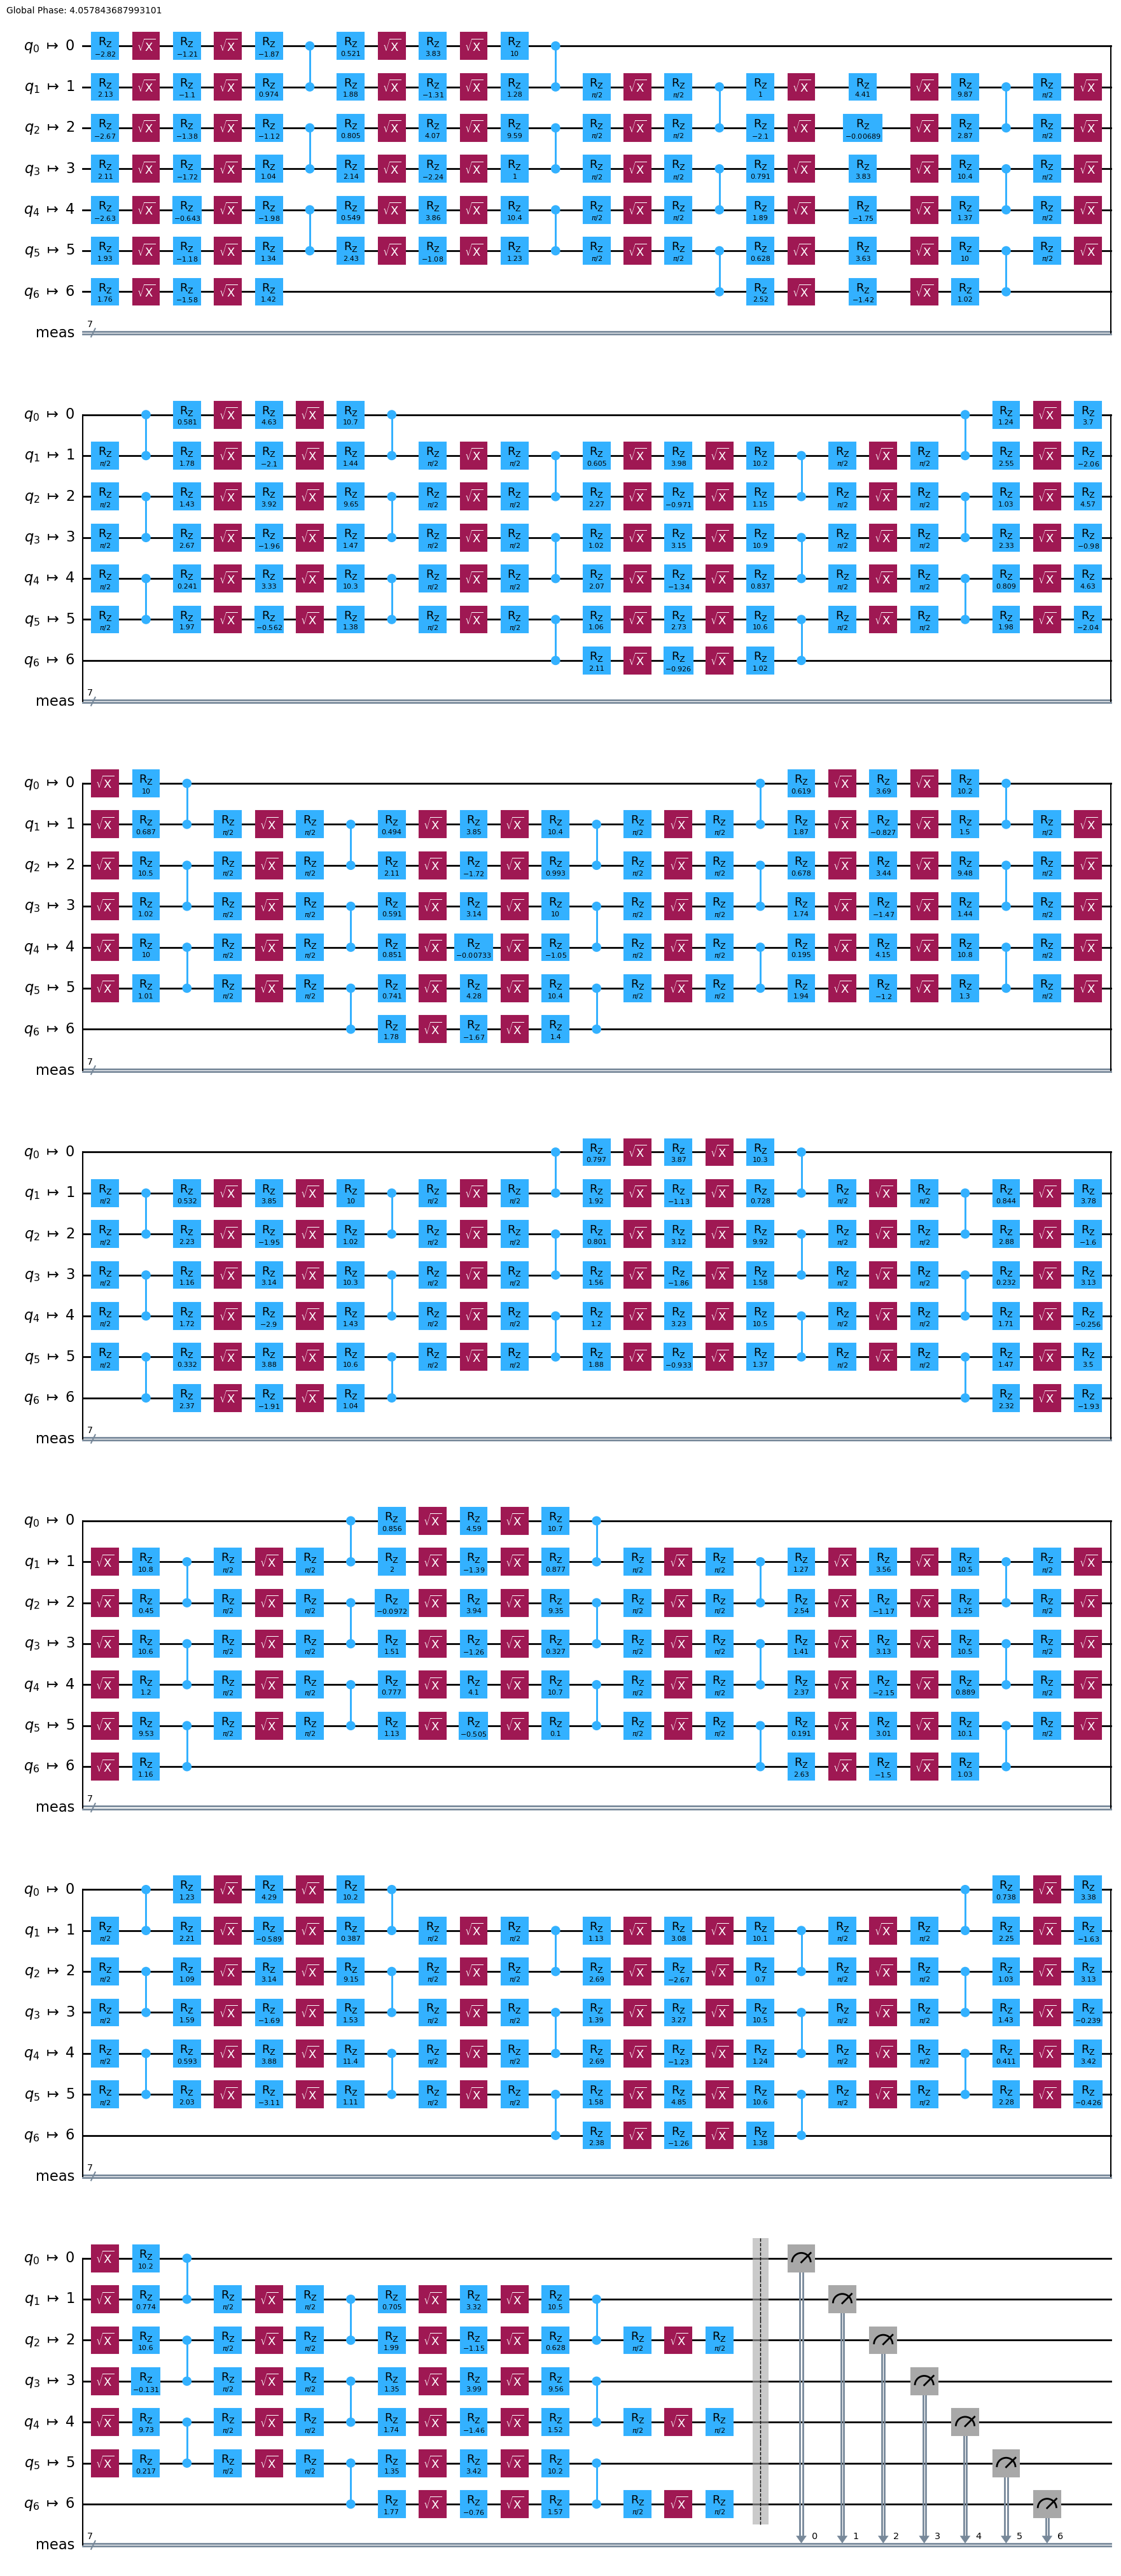

In [24]:
from qiskit.transpiler import generate_preset_pass_manager

# Transpile the circuit
pass_manager = generate_preset_pass_manager(
    optimization_level=1, backend=backend
)
transpiled_circ = pass_manager.run(variational_circuit(params_dict[1], optimal_layers[0]))
 
# View the transpiled circuit
transpiled_circ.draw(output="mpl", idle_wires=False)

In [27]:
pm = generate_preset_pass_manager(optimization_level=1, backend=backend)
sampler = Sampler(mode=backend)

In [28]:
def calculate_results_hardware(params, layers):

    circuit = variational_circuit(params, layers)
    transpiled_circuit = pm.run(circuit)

    job = sampler.run([transpiled_circuit])
    job_result = job.result()
    return job_result[0].data.meas.get_counts(), job.job_id()

In [29]:
counts, id = calculate_results_hardware(params_dict[1], optimal_layers[0])

In [31]:
counts_compare, _ = calculate_results(params_dict[1], optimal_layers[0])
print(counts_compare)

{'1110110': 506, '1101110': 458, '1111010': 50, '1111100': 7, '1011110': 3}


In [ ]:
print(counts, id)


{'1000111': 8, '1110001': 116, '1101110': 463, '1111101': 65, '1111010': 78, '1010101': 10, '0101101': 9, '0001101': 8, '1111100': 117, '1001000': 15, '1001001': 18, '1011010': 16, '1110011': 109, '1110000': 70, '1101111': 29, '1101101': 47, '1111111': 99, '0010011': 18, '1111011': 83, '1100011': 12, '1101010': 56, '1101011': 99, '1110110': 558, '0001001': 13, '1111110': 176, '1001110': 65, '1011110': 29, '1100000': 10, '1101001': 87, '1110100': 59, '0011001': 11, '1101000': 57, '0001110': 46, '1110101': 69, '1010110': 69, '0101111': 7, '0111011': 9, '1010010': 12, '0110011': 11, '0110001': 19, '1010000': 12, '1010001': 19, '0101000': 8, '1111000': 70, '0101110': 58, '1001011': 21, '0110110': 66, '0000101': 6, '1101100': 53, '0011100': 16, '0100110': 15, '1000101': 14, '0110111': 2, '1010011': 16, '0110101': 7, '0111111': 7, '0001010': 10, '1011011': 12, '0011010': 9, '1000000': 8, '0000011': 5, '0011000': 13, '1100110': 40, '0100000': 7, '1001111': 6, '0010001': 20, '1011001': 9, '001

In [33]:
print(counts['1110110'])
print(counts['1101110'])
print(counts['1111010'])
print(counts['1111100'])
print(counts['1011110'])

558
463
78
117
29


In [35]:
counts_dict = {}
counts_dict[1] = counts

In [40]:
for n_steps in range(2, nb_timesteps + 1):
    print("In Progress: Step " + str(n_steps) + ".")
    counts, id = calculate_results_hardware(params_dict[n_steps], optimal_layers[n_steps-1])
    counts_dict[n_steps] = counts

    with open("jobs_id.csv", "a") as file:
        file.write(id)

In Progress: Step 2.
In Progress: Step 3.
In Progress: Step 4.
In Progress: Step 5.
In Progress: Step 6.
In Progress: Step 7.
In Progress: Step 8.
In Progress: Step 9.
In Progress: Step 10.


{'1000111': 8, '1110001': 116, '1101110': 463, '1111101': 65, '1111010': 78, '1010101': 10, '0101101': 9, '0001101': 8, '1111100': 117, '1001000': 15, '1001001': 18, '1011010': 16, '1110011': 109, '1110000': 70, '1101111': 29, '1101101': 47, '1111111': 99, '0010011': 18, '1111011': 83, '1100011': 12, '1101010': 56, '1101011': 99, '1110110': 558, '0001001': 13, '1111110': 176, '1001110': 65, '1011110': 29, '1100000': 10, '1101001': 87, '1110100': 59, '0011001': 11, '1101000': 57, '0001110': 46, '1110101': 69, '1010110': 69, '0101111': 7, '0111011': 9, '1010010': 12, '0110011': 11, '0110001': 19, '1010000': 12, '1010001': 19, '0101000': 8, '1111000': 70, '0101110': 58, '1001011': 21, '0110110': 66, '0000101': 6, '1101100': 53, '0011100': 16, '0100110': 15, '1000101': 14, '0110111': 2, '1010011': 16, '0110101': 7, '0111111': 7, '0001010': 10, '1011011': 12, '0011010': 9, '1000000': 8, '0000011': 5, '0011000': 13, '1100110': 40, '0100000': 7, '1001111': 6, '0010001': 20, '1011001': 9, '001

Text(0.5, 0, 'T')

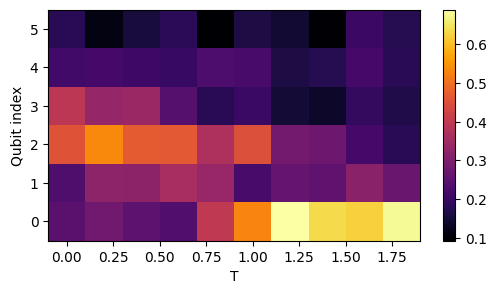

In [41]:
res_all_circuits = []
for n_steps in range(1, nb_timesteps + 1):
    #res, id = calculate_results_hardware(params_dict[n_steps], optimal_layers[n_steps-1])
    res = counts_dict[n_steps]
    print(res)

    # create a new row to add to magnetization array
    row = [0 for _ in range(N)]
    prob = 0
    for key, value in res.items():

        
        if key[-1] == "0":
            prob += value
            #for i in range(0, N):
            for i in range(0, N):
                # if the other qubits have a result of 0, then add the probabilities to that qubit
                if key[i] == '0':
                    row[N - i - 1] += value

    res_all_circuits += [[x/prob for x in row]]

res_all_circuits = np.array(res_all_circuits)

print(res_all_circuits.T.shape)
fig = plt.figure(figsize=((nb_timesteps + 2)/2 , N/2), facecolor='white')
im = plt.pcolormesh([timestep_duration * i for i in range(nb_timesteps)], np.arange(0,N,1), res_all_circuits.T, cmap='inferno')
fig.colorbar(im)
plt.ylabel('Qubit index')
plt.xlabel('T')